<a href="https://colab.research.google.com/github/ItsShi/Mono-Depth/blob/main/poses_monodepth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# prepare data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q /content/drive/MyDrive/SCARED/SCARED_video

In [3]:
!unzip -q /content/drive/MyDrive/SCARED/SCARED_camera

In [4]:
video_pth = '/content/SCARED_video/d{}k{}_rgb.mp4'
frame_pth = '/content/SCARED_frames/d{}k{}_{:06d}.jpg'

camera_pth = '/content/SCARED_camera/d{}k{}_frame_data.tar.gz'

!mkdir /content/SCARED_frames

In [5]:
import cv2

for i in range(3):
  for j in range(4):
      cap = cv2.VideoCapture(video_pth.format(i+1, j+1)) 
      print(video_pth[-14:-8].format(i+1, j+1), " {}frames".format(cap.get(cv2.CAP_PROP_FRAME_COUNT)))

      count = 0
      success = True
      while success:
        success, image = cap.read()
        if success: 
           cv2.imwrite((frame_pth.format(i+1, j+1, count)), image[:1024,:,:], [int(cv2.IMWRITE_JPEG_QUALITY), 100]) #jpg_quality only left image
           count = count + 1 
      # print(count) 

d1k1  197.0frames
d1k2  280.0frames
d1k3  471.0frames
d1k4  0.0frames
d2k1  88.0frames
d2k2  1033.0frames
d2k3  1102.0frames
d2k4  2114.0frames
d3k1  329.0frames
d3k2  540.0frames
d3k3  448.0frames
d3k4  834.0frames
d4k1  728.0frames
d4k2  540.0frames
d4k3  407.0frames
d4k4  348.0frames


In [6]:
import tarfile
import numpy as np
import json
from scipy.spatial.transform import Rotation as R

poses_dict = {}
for i in range(4):
  for j in range(4):
    poses_list = []
    count = 0
    try:
      with tarfile.open(camera_pth.format(i+1,j+1), "r:gz") as frame_data:
        samples = frame_data.getmembers()
        for sample in samples:
            with frame_data.extractfile(sample) as sample_json:
                pose = np.array(json.loads(sample_json.read())["camera-pose"])
                poses_list.append(pose) 
                count = count+1
    except: 
      print(camera_pth.format(i+1,j+1))
      poses_dict["d{}k{}".format(i+1,j+1)] = np.empty((0,0,0))
    poses_dict["d{}k{}".format(i+1,j+1)] = np.array(poses_list)
    print("d{}k{}: {} poses".format(i+1,j+1,count))

print("translation vec: \n", poses_dict["d2k1"][0,:,-1]) # d2k1 has outlier translation vector

Rot_mat = poses_dict["d2k1"][0,:3,:3]
print("Rotation matrix: \n", Rot_mat, np.linalg.det(Rot_mat))

r = R.from_matrix(Rot_mat).as_matrix()
print("SO(3) estimate: \n", r, np.linalg.det(r))

print(Rot_mat.T)
print(np.linalg.inv(Rot_mat)) 

d1k1: 197 poses
d1k2: 280 poses
d1k3: 471 poses
/content/SCARED_camera/d1k4_frame_data.tar.gz
d1k4: 0 poses
d2k1: 88 poses
d2k2: 1033 poses
d2k3: 1102 poses
d2k4: 2114 poses
d3k1: 329 poses
d3k2: 1597 poses
d3k3: 448 poses
d3k4: 834 poses
d4k1: 728 poses
d4k2: 540 poses
d4k3: 407 poses
d4k4: 348 poses
translation vec: 
 [-2.18090725  4.43309724 25.17780985  1.        ]
Rotation matrix: 
 [[ 0.99988652  0.00388902 -0.01454001]
 [-0.00346674  0.99957446  0.02895865]
 [ 0.01464639 -0.02890491  0.99947436]] 0.9999991593445312
SO(3) estimate: 
 [[ 0.99988673  0.00388904 -0.01453998]
 [-0.00346672  0.9995746   0.02895863]
 [ 0.01464642 -0.02890494  0.99947486]] 0.9999999999999999
[[ 0.99988652 -0.00346674  0.01464639]
 [ 0.00388902  0.99957446 -0.02890491]
 [-0.01454001  0.02895865  0.99947436]]
[[ 0.99988693 -0.0034667   0.01464645]
 [ 0.00388906  0.99957474 -0.02890499]
 [-0.01453997  0.02895861  0.99947535]]


In [7]:
# !pip -q install kornia

In [8]:
# !zip -r /content/drive/MyDrive/SCARED/SCARED_frames.zip /content/SCARED_frames

# util
https://en.wikipedia.org/wiki/Rotation_matrix


rotation vector to rotation matrix:

$\|\mathbf{p}\|^{2}=\left[p_{1} \cdots p_{n}\right]\left[\begin{array}{c}
p_{1} \\
\vdots \\
p_{n}
\end{array}\right]=\mathbf{p}^{\top} \mathbf{p}$

$R=\left[\begin{array}{ccc}
\cos \theta+u_{x}^{2}(1-\cos \theta) & u_{x} u_{y}(1-\cos \theta)-u_{z} \sin \theta & u_{x} u_{z}(1-\cos \theta)+u_{y} \sin \theta \\
u_{y} u_{x}(1-\cos \theta)+u_{z} \sin \theta & \cos \theta+u_{y}^{2}(1-\cos \theta) & u_{y} u_{z}(1-\cos \theta)-u_{x} \sin \theta \\
u_{z} u_{x}(1-\cos \theta)-u_{y} \sin \theta & u_{z} u_{y}(1-\cos \theta)+u_{x} \sin \theta & \cos \theta \dashv u_{z}^{2}(1-\cos \theta)
\end{array}\right] .$


$\boldsymbol{R}=\cos \theta \boldsymbol{I}+(1-\cos \theta) \boldsymbol{n} \boldsymbol{n}^{T}+\sin \theta \boldsymbol{n}^{\wedge}$

rot mat to rot vec:

$\theta=\arccos \left(\frac{\operatorname{tr}(\boldsymbol{R})-1}{2}\right)$

In [9]:
# !pip -q install torchgeometry

# import torch
# import torchgeometry as tgm

# quaternion = tgm.rotation_matrix_to_quaternion(rot_mat)
# angleaxis = tgm.quaternion_to_angle_axis(quaternion)

# angle = tgm.rotation_matrix_to_angle_axis(rot_mat)
# print(angleaxis)

In [10]:
# https://github.com/Wallacoloo/printipi/blob/master/util/rotation_matrix.py

In [11]:
import torch

def rotation_matrix_to_quaternion(rotation_matrix, eps=1e-6):
    """Convert 3x4 rotation matrix to 4d quaternion vector

    This algorithm is based on algorithm described in
    https://github.com/KieranWynn/pyquaternion/blob/master/pyquaternion/quaternion.py#L201

    Args:
        rotation_matrix (Tensor): the rotation matrix to convert.

    Return:
        Tensor: the rotation in quaternion

    Shape:
        - Input: :math:`(N, 3, 4)`
        - Output: :math:`(N, 4)`

    Example:
        >>> input = torch.rand(4, 3, 4)  # Nx3x4
        >>> output = tgm.rotation_matrix_to_quaternion(input)  # Nx4
    """
    if not torch.is_tensor(rotation_matrix):
        raise TypeError("Input type is not a torch.Tensor. Got {}".format(
            type(rotation_matrix)))

    if len(rotation_matrix.shape) > 3:
        raise ValueError(
            "Input size must be a three dimensional tensor. Got {}".format(
                rotation_matrix.shape))
    if not rotation_matrix.shape[-2:] == (3, 4):
        raise ValueError(
            "Input size must be a N x 3 x 4  tensor. Got {}".format(
                rotation_matrix.shape))

    rmat_t = torch.transpose(rotation_matrix, 1, 2)

    mask_d2 = rmat_t[:, 2, 2] < eps

    mask_d0_d1 = rmat_t[:, 0, 0] > rmat_t[:, 1, 1]
    mask_d0_nd1 = rmat_t[:, 0, 0] < -rmat_t[:, 1, 1]

    t0 = 1 + rmat_t[:, 0, 0] - rmat_t[:, 1, 1] - rmat_t[:, 2, 2]
    q0 = torch.stack([rmat_t[:, 1, 2] - rmat_t[:, 2, 1],
                      t0, rmat_t[:, 0, 1] + rmat_t[:, 1, 0],
                      rmat_t[:, 2, 0] + rmat_t[:, 0, 2]], -1)
    t0_rep = t0.repeat(4, 1).t()

    t1 = 1 - rmat_t[:, 0, 0] + rmat_t[:, 1, 1] - rmat_t[:, 2, 2]
    q1 = torch.stack([rmat_t[:, 2, 0] - rmat_t[:, 0, 2],
                      rmat_t[:, 0, 1] + rmat_t[:, 1, 0],
                      t1, rmat_t[:, 1, 2] + rmat_t[:, 2, 1]], -1)
    t1_rep = t1.repeat(4, 1).t()

    t2 = 1 - rmat_t[:, 0, 0] - rmat_t[:, 1, 1] + rmat_t[:, 2, 2]
    q2 = torch.stack([rmat_t[:, 0, 1] - rmat_t[:, 1, 0],
                      rmat_t[:, 2, 0] + rmat_t[:, 0, 2],
                      rmat_t[:, 1, 2] + rmat_t[:, 2, 1], t2], -1)
    t2_rep = t2.repeat(4, 1).t()

    t3 = 1 + rmat_t[:, 0, 0] + rmat_t[:, 1, 1] + rmat_t[:, 2, 2]
    q3 = torch.stack([t3, rmat_t[:, 1, 2] - rmat_t[:, 2, 1],
                      rmat_t[:, 2, 0] - rmat_t[:, 0, 2],
                      rmat_t[:, 0, 1] - rmat_t[:, 1, 0]], -1)
    t3_rep = t3.repeat(4, 1).t()

    mask_c0 = mask_d2 * mask_d0_d1
    mask_c1 = mask_d2 * (~mask_d0_d1)
    mask_c2 = (~mask_d2) * mask_d0_nd1
    mask_c3 = (~mask_d2) * (~mask_d0_nd1)
    mask_c0 = mask_c0.view(-1, 1).type_as(q0)
    mask_c1 = mask_c1.view(-1, 1).type_as(q1)
    mask_c2 = mask_c2.view(-1, 1).type_as(q2)
    mask_c3 = mask_c3.view(-1, 1).type_as(q3)

    q = q0 * mask_c0 + q1 * mask_c1 + q2 * mask_c2 + q3 * mask_c3
    q /= torch.sqrt(t0_rep * mask_c0 + t1_rep * mask_c1 +  # noqa
                    t2_rep * mask_c2 + t3_rep * mask_c3)  # noqa
    q *= 0.5
    return q



def quaternion_to_angle_axis(quaternion: torch.Tensor) -> torch.Tensor:
    """Convert quaternion vector to angle axis of rotation.

    Adapted from ceres C++ library: ceres-solver/include/ceres/rotation.h

    Args:
        quaternion (torch.Tensor): tensor with quaternions.

    Return:
        torch.Tensor: tensor with angle axis of rotation.

    Shape:
        - Input: :math:`(*, 4)` where `*` means, any number of dimensions
        - Output: :math:`(*, 3)`

    Example:
        >>> quaternion = torch.rand(2, 4)  # Nx4
        >>> angle_axis = tgm.quaternion_to_angle_axis(quaternion)  # Nx3
    """
    if not torch.is_tensor(quaternion):
        raise TypeError("Input type is not a torch.Tensor. Got {}".format(
            type(quaternion)))

    if not quaternion.shape[-1] == 4:
        raise ValueError("Input must be a tensor of shape Nx4 or 4. Got {}"
                         .format(quaternion.shape))
    # unpack input and compute conversion
    q1: torch.Tensor = quaternion[..., 1]
    q2: torch.Tensor = quaternion[..., 2]
    q3: torch.Tensor = quaternion[..., 3]
    sin_squared_theta: torch.Tensor = q1 * q1 + q2 * q2 + q3 * q3

    sin_theta: torch.Tensor = torch.sqrt(sin_squared_theta)
    cos_theta: torch.Tensor = quaternion[..., 0]
    two_theta: torch.Tensor = 2.0 * torch.where(
        cos_theta < 0.0,
        torch.atan2(-sin_theta, -cos_theta),
        torch.atan2(sin_theta, cos_theta))

    k_pos: torch.Tensor = two_theta / sin_theta
    k_neg: torch.Tensor = 2.0 * torch.ones_like(sin_theta)
    k: torch.Tensor = torch.where(sin_squared_theta > 0.0, k_pos, k_neg)

    angle_axis: torch.Tensor = torch.zeros_like(quaternion)[..., :3]
    angle_axis[..., 0] += q1 * k
    angle_axis[..., 1] += q2 * k
    angle_axis[..., 2] += q3 * k
    return angle_axis

In [12]:
def angle_axis_to_rotation_matrix(angle_axis):
    """Convert 3d vector of axis-angle rotation to 4x4 rotation matrix

    Args:
        angle_axis (Tensor): tensor of 3d vector of axis-angle rotations.

    Returns:
        Tensor: tensor of 4x4 rotation matrices.

    Shape:
        - Input: :math:`(N, 3)`
        - Output: :math:`(N, 4, 4)`

    Example:
        >>> input = torch.rand(1, 3)  # Nx3
        >>> output = tgm.angle_axis_to_rotation_matrix(input)  # Nx4x4
    """
    def _compute_rotation_matrix(angle_axis, theta2, eps=1e-6):
        # We want to be careful to only evaluate the square root if the
        # norm of the angle_axis vector is greater than zero. Otherwise
        # we get a division by zero.
        k_one = 1.0
        theta = torch.sqrt(theta2)
        wxyz = angle_axis / (theta + eps)
        wx, wy, wz = torch.chunk(wxyz, 3, dim=1)
        cos_theta = torch.cos(theta)
        sin_theta = torch.sin(theta)

        r00 = cos_theta + wx * wx * (k_one - cos_theta)
        r10 = wz * sin_theta + wx * wy * (k_one - cos_theta)
        r20 = -wy * sin_theta + wx * wz * (k_one - cos_theta)
        r01 = wx * wy * (k_one - cos_theta) - wz * sin_theta
        r11 = cos_theta + wy * wy * (k_one - cos_theta)
        r21 = wx * sin_theta + wy * wz * (k_one - cos_theta)
        r02 = wy * sin_theta + wx * wz * (k_one - cos_theta)
        r12 = -wx * sin_theta + wy * wz * (k_one - cos_theta)
        r22 = cos_theta + wz * wz * (k_one - cos_theta)
        rotation_matrix = torch.cat(
            [r00, r01, r02, r10, r11, r12, r20, r21, r22], dim=1)
        return rotation_matrix.view(-1, 3, 3)

    def _compute_rotation_matrix_taylor(angle_axis):
        rx, ry, rz = torch.chunk(angle_axis, 3, dim=1)
        k_one = torch.ones_like(rx)
        rotation_matrix = torch.cat(
            [k_one, -rz, ry, rz, k_one, -rx, -ry, rx, k_one], dim=1)
        return rotation_matrix.view(-1, 3, 3)

    # stolen from ceres/rotation.h

    _angle_axis = torch.unsqueeze(angle_axis, dim=1)
    theta2 = torch.matmul(_angle_axis, _angle_axis.transpose(1, 2))
    theta2 = torch.squeeze(theta2, dim=1)

    # compute rotation matrices
    rotation_matrix_normal = _compute_rotation_matrix(angle_axis, theta2)
    rotation_matrix_taylor = _compute_rotation_matrix_taylor(angle_axis)

    # create mask to handle both cases
    eps = 1e-6
    print(theta2.device)
    mask = (theta2 > eps).view(-1, 1, 1).to(theta2.device)
    mask_pos = (mask).type_as(theta2)
    mask_neg = (mask == False).type_as(theta2)  # noqa

    # create output pose matrix
    batch_size = angle_axis.shape[0]
    rotation_matrix = torch.eye(4).to(angle_axis.device).type_as(angle_axis)
    rotation_matrix = rotation_matrix.view(1, 4, 4).repeat(batch_size, 1, 1)
    # fill output matrix with masked values
    rotation_matrix[..., :3, :3] = \
        mask_pos * rotation_matrix_normal + mask_neg * rotation_matrix_taylor
    return rotation_matrix  # Nx4x4

In [13]:
# # relative to absolute
# def dump(source_to_target_transformations):
#     Ms = []
#     cam_to_world = np.eye(4)
#     Ms.append(cam_to_world)
#     for source_to_target_transformation in source_to_target_transformations:
#         cam_to_world = np.dot(source_to_target_transformation, cam_to_world)
#         Ms.append(cam_to_world)
#     return Ms
# pred_p = pred_poses.copy()
# pred_p = np.array(dump(pred_p))

# gt_p = poses_list.copy()
# gt_p.insert(0,np.eye(4)) # gt_p = dump(gt_p)
# gt_p = np.array(gt_p)
# print(gt_p.shape)

# # scale
# sum_product = np.sum(gt_p[:, :3, 3] * pred_p[:, :3, 3]) 
# scale = sum_product / np.sum(pred_p[:, :3, 3] ** 2) 
# print("scale: ", scale)
# scaled_p = pred_p * scale

# # last column first three 
# pred_points = [] 
# origin = np.array([[0], [0], [0], [1]]) # (4, 1) 
# for i in range(len(scaled_p)):
#   pred_points.append(np.dot(scaled_p[i], origin))# last column to a column vec
# pred_points = np.array(pred_points)
# # the same
# gt_points = []
# for i in range(len(gt_p)):
#   gt_points.append(np.array([gt_p[i,:,3]]).T)
# gt_points = np.array(gt_points)

In [14]:
# test rotation conversion
rot_mat = torch.tensor(poses_dict["d1k1"][2,:3,:4]).unsqueeze(0)
print(rot_mat[0])

quaternion = rotation_matrix_to_quaternion(rot_mat)
print(quaternion[0])

angle_axis = quaternion_to_angle_axis(quaternion)
print(angle_axis[0])

rot_mat = angle_axis_to_rotation_matrix(angle_axis)
print(rot_mat[0], np.linalg.det(rot_mat[0]))

tensor([[ 9.9997e-01, -7.3668e-03, -5.4032e-04, -6.9165e-02],
        [ 7.3653e-03,  9.9997e-01, -2.6597e-03, -3.4057e-01],
        [ 5.5988e-04,  2.6559e-03,  1.0000e+00,  9.2608e-01]],
       dtype=torch.float64)
tensor([ 9.9999e-01,  1.3289e-03, -2.7505e-04,  3.6831e-03],
       dtype=torch.float64)
tensor([ 0.0027, -0.0006,  0.0074], dtype=torch.float64)
cpu
tensor([[ 9.9997e-01, -7.3658e-03, -5.4024e-04,  0.0000e+00],
        [ 7.3644e-03,  9.9997e-01, -2.6595e-03,  0.0000e+00],
        [ 5.5982e-04,  2.6554e-03,  1.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64) 0.9999999764541212


In [15]:
# test abs poses to rel pose
p1 = poses_dict["d1k1"][0,:,:]
p2 = poses_dict["d1k1"][1,:,:]
p_rel = np.dot(p2, np.linalg.inv(p1))
# print(p1)
print(p2)
# print(p_rel)
print(np.dot(p_rel, p1))

[[ 9.99986505e-01 -5.21717555e-03 -3.65047748e-04 -4.67234222e-02]
 [ 5.21652895e-03  9.99985165e-01 -1.74441123e-03 -2.23215699e-01]
 [ 3.74092521e-04  1.74257499e-03  9.99998793e-01  6.31324424e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99986505e-01 -5.21717555e-03 -3.65047748e-04 -4.67234222e-02]
 [ 5.21652895e-03  9.99985165e-01 -1.74441123e-03 -2.23215699e-01]
 [ 3.74092521e-04  1.74257499e-03  9.99998793e-01  6.31324424e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


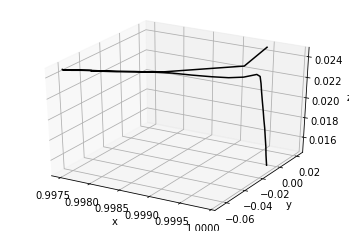

In [16]:
# visualise translation
import matplotlib.pyplot as plt

end=35
e=477
dk = "d2k1"
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
figure1, = ax.plot(poses_dict[dk][:end, 0, 0], poses_dict[dk][:end, 1, 0], poses_dict[dk][:end, 2, 0], c='k')
# figure1, = ax.plot(vo[i][end:e, 0, 0], vo[i][end:e, 1, 0], vo[i][end:e, 2, 0], c='r')
plt.savefig('poses.png')
plt.show()

# dataloader

all frames: 9459 train frames: 70
197 471
r_vec: tensor([[0.0006, 0.0005, 0.0003]], dtype=torch.float64)  t: [ 0.0808084 -0.0875198 -0.2875619  1.       ]


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f267079a490>)

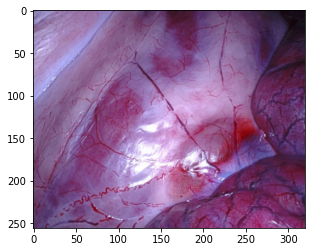

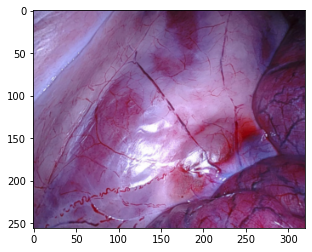

In [54]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from glob import glob
from PIL import Image

os.chdir('/content')
class MyDataset(Dataset):
    def __init__(self, path_frame=None, transform=None):
        self.path_frame = path_frame
        self.transform = transform
        self.len = len(self.path_frame)
        self.poses_dictionary = self._get_poses_dict()

    def __len__(self):
      return len(self.path_frame)   
    
    def _get_poses_dict(self):# read poses from tar/tar.gz files to a dictionary
        poses_dict = {}
        for i in range(4):
          for j in range(4):
            poses_list = []
            count = 0
            try:
              with tarfile.open('/content/SCARED_camera/d{}k{}_frame_data.tar.gz'.format(i+1,j+1), "r:gz") as frame_data:
                samples = frame_data.getmembers()
                for sample in samples:
                    with frame_data.extractfile(sample) as sample_json:
                        pose = np.array(json.loads(sample_json.read())["camera-pose"])
                        poses_list.append(pose) 
                        count = count+1
              poses_dict['d{}k{}'.format(i+1,j+1)] = np.array(poses_list)
            except: pass 
        return poses_dict

    def _get_rotV_from_T(self, T): # after abs to rel conversion, convert pose to axis angle
      
        rot_mat = torch.tensor(T[:3,:4]).unsqueeze(0)
        
        quaternion = rotation_matrix_to_quaternion(rot_mat)
        rotV = quaternion_to_angle_axis(quaternion)
        return rotV 
        # print(rot_mat)# pass

    def __getitem__(self, i):
        path_frame = self.path_frame[i]
        dataset_keyframe_idx = path_frame[-15:-11]
        frame_idx = int(path_frame[-10:-4])
        # print(dataset_keyframe_idx)

        img = Image.open(self.path_frame[i]).convert('RGB')
        pose = self.poses_dictionary[dataset_keyframe_idx][frame_idx,:,:] #poses_dict["d1k1"][0,:,:]
        try:
          img_next = Image.open(path_frame.replace(path_frame[-10:-4], "{:06d}".format(frame_idx+1))).convert('RGB')
          pose_next = self.poses_dictionary[dataset_keyframe_idx][frame_idx+1,:,:]
        except: 
          print(dataset_keyframe_idx, path_frame[-10:-4],  "{:06d}".format(frame_idx+1)) 
          img_next = img
          pose_next = pose
        if self.transform:
            img, img_next = self.transform(img), self.transform(img_next)

        abs_to_rel_pose = np.dot(pose_next, np.linalg.inv(pose))
      

        r_vec = self._get_rotV_from_T(abs_to_rel_pose)
        t = abs_to_rel_pose[:,-1]
        return img, img_next, r_vec, t

transform_all = transforms.Compose([
    transforms.Resize((256, 320)),
    transforms.ToTensor(),
])

path_frames_all = glob('SCARED_frames/*.jpg') # 9459 from first 4 datasets
path_frames_train = path_frames_all[:70]
path_frames_valid = path_frames_all[70:100]
print('all frames:', len(path_frames_all),'train frames:', len(path_frames_train))

path_frames_d1k1 = glob('SCARED_frames/d1k1*.jpg') 
path_frames_d1k3 = glob('SCARED_frames/d1k3*.jpg') 
print(len(path_frames_d1k1), len(path_frames_d1k3))

dataset_train = MyDataset(path_frame=path_frames_train, transform=transform_all)
dataset_valid = MyDataset(path_frame=path_frames_valid, transform=transform_all)
# print(dataset_train[0][0].shape, dataset_train[0][1].shape, dataset_train[0][1].min(), dataset_train[0][1].max())

dk = 3
print('r_vec:',dataset_train[dk][2], ' t:', dataset_train[dk][3])
plt.figure(), plt.imshow(dataset_train[dk][0].permute(1,2,0))
plt.figure(), plt.imshow(dataset_train[dk][1].permute(1,2,0))

In [18]:
# images = [dataset_train[i][0], dataset_train[i][1]]
# inputs_cat = torch.cat(images, 0)[None]
# print(inputs_cat.size())

# network

In [19]:
import torch
import os


!git clone https://github.com/nianticlabs/monodepth2.git
%cd monodepth2
import networks
from utils import download_model_if_doesnt_exist
model_name = "mono_640x192"# model_name = 'mono_1024x320'


# kitti weights
device = 'cuda' if torch.cuda.is_available() else 'cpu'
download_model_if_doesnt_exist(model_name)
# encoder_path = os.path.join("models", model_name, "encoder.pth")
# depth_decoder_path = os.path.join("models", model_name, "depth.pth")
pose_encoder_path = os.path.join("models", model_name, "pose_encoder.pth")
pose_decoder_path = os.path.join("models", model_name, "pose.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))
pose_encoder = networks.ResnetEncoder(18, "pretrained", 2)
pose_decoder = networks.PoseDecoder(encoder.num_ch_enc,1,2)#num_input_features, num_frames_to_predict_for

# loaded_dict_enc = torch.load(encoder_path, map_location=device)
# filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
# encoder.load_state_dict(filtered_dict_enc)

# loaded_dict = torch.load(depth_decoder_path, map_location=device)
# depth_decoder.load_state_dict(loaded_dict)

pose_encoder.load_state_dict(torch.load(pose_encoder_path, map_location=device))

pose_decoder.load_state_dict(torch.load(pose_decoder_path, map_location=device))

encoder.load_state_dict(torch.load("/content/drive/MyDrive/SCARED/encoder_ssim.pth", map_location=device))
depth_decoder.load_state_dict(torch.load("/content/drive/MyDrive/SCARED/decoder_ssim.pth", map_location=device))
print(device)
os.chdir('/content')

Cloning into 'monodepth2'...
remote: Enumerating objects: 180, done.
remote: Total 180 (delta 0), reused 0 (delta 0), pack-reused 180
Receiving objects: 100% (180/180), 10.27 MiB | 20.38 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/monodepth2
-> Downloading pretrained model to models/mono_640x192.zip
   Unzipping model...
   Model unzipped to models/mono_640x192


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and may be removed in the future. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

cpu


# retrain

absolute trajectory error

$A T E=\sqrt{\frac{1}{T} \sum_{t=1}^{T}\left\|\operatorname{trans}\left(\boldsymbol{Q}_{t}^{-1} \boldsymbol{\Delta}_{S} \boldsymbol{P}_{t}\right)\right\|}$

Q is the ground truth, P is the estimated, s is the rigid transformation

relative translation error

$R T E=\sqrt{\frac{1}{T} \sum_{t=1}^{T}\left\|\operatorname{trans}\left(\boldsymbol{E}_{t}\right)\right\|}$

relative rotation error

$R R E=\frac{1}{T} \sum_{t=1}^{T}\left\|\operatorname{rot}\left(\boldsymbol{E}_{t}\right)\right\|$



In [21]:
import torch.nn as nn

class RelPoseCriterion(nn.Module):
    def __init__(self, alpha=1):
        super().__init__()
        self.alpha = alpha
        self.q_loss = nn.MSELoss()
        self.t_loss = nn.MSELoss()

    def forward(self, q_gt, t_gt, q_est, t_est):
        t_loss = self.t_loss(t_est, t_gt)
        q_loss = self.q_loss(q_est, q_gt)

        loss_total = t_loss + self.alpha * q_loss
        return loss_total, t_loss.item(), q_loss.item()

In [37]:
def train(model, trainloader, optimizer, criterion):
    model[0].train()
    model[1].train()
    for i_batch, s_batch in enumerate(trainloader):
        print(i_batch)
        images = [s_batch[0].to(device), s_batch[1].to(device)]
        inputs_cat = torch.cat(images, 1)
        feat = [pose_encoder(inputs_cat)] # [torch.Size([1, 64, 128, 160]),torch.Size([1, 64, 64, 80]),torch.Size([1, 128, 32, 40]),torch.Size([1, 256, 16, 20]),torch.Size([1, 512, 8, 10]]
        axisangle, translation = pose_decoder(feat) #torch.Size([N, 2, 1, 3]) torch.Size([N, 2, 1, 3])
      
        %cd monodepth2
        from layers import transformation_from_parameters,  get_translation_matrix,  rot_from_axisangle
        M = transformation_from_parameters(axisangle[:, 0], translation[:, 0])
        axisangle = quaternion_to_angle_axis(rotation_matrix_to_quaternion(M[:,:3,:])).float()
        translation = M[:,:,3].float()
        # print(axisangle.size(), s_batch[2].squeeze().size())# torch.Size([64, 1, 3]) 
        # print(translation.size(), s_batch[3].size())#  torch.Size([64, 4])

        loss,_,_ = criterion(s_batch[2].squeeze().float().to(device), s_batch[3].float().to(device), axisangle, translation)
        # print(loss.dtype, s_batch[2].squeeze().to(device).dtype, s_batch[3].to(device).dtype, axisangle.dtype, translation.dtype)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [23]:
# from https://github.com/tinghuiz/SfMLearner
def compute_ate(gtruth_xyz, pred_xyz_o):

    # Make sure that the first matched frames align (no need for rotational alignment as
    # all the predicted/ground-truth snippets have been converted to use the same coordinate
    # system with the first frame of the snippet being the origin).
    offset = gtruth_xyz[0] - pred_xyz_o[0]
    pred_xyz = pred_xyz_o + offset[None, :]

    # Optimize the scaling factor
    scale = np.sum(gtruth_xyz * pred_xyz) / np.sum(pred_xyz ** 2)
    alignment_error = pred_xyz * scale - gtruth_xyz
    rmse = np.sqrt(np.sum(alignment_error ** 2)) / gtruth_xyz.shape[0]

In [61]:
os.chdir('/content')
def test(model, testloader):
    model[0].eval()
    model[1].eval()
    t_mse_all = []
    rot_mse_all = []

    with torch.no_grad():
        for i_batch, s_batch in enumerate(testloader):
            images = [s_batch[0].to(device), s_batch[1].to(device)]
            inputs_cat = torch.cat(images, 1)
            feat = [pose_encoder(inputs_cat)] # [torch.Size([1, 64, 128, 160]),torch.Size([1, 64, 64, 80]),torch.Size([1, 128, 32, 40]),torch.Size([1, 256, 16, 20]),torch.Size([1, 512, 8, 10]]
            axisangle, translation = pose_decoder(feat)

            %cd monodepth2
            from layers import transformation_from_parameters,  get_translation_matrix,  rot_from_axisangle
            M = transformation_from_parameters(axisangle[:, 0], translation[:, 0])
            axisangle = quaternion_to_angle_axis(rotation_matrix_to_quaternion(M[:,:3,:])).float()
            translation = M[:,:,3].float()

            # outputs = nn.Sigmoid()(outputs)
            # loss,_,_ = criterion(s_batch[2].to(device), s_batch[3].to(device), axisangle, translation)
            rot_mse = nn.MSELoss()(s_batch[2].to(device), axisangle)
            t_mse = nn.MSELoss()(s_batch[3].to(device), translation)
            rot_mse_all.append(rot_mse.item())
            t_mse_all.append(t_mse.item())
        return np.mean(t_mse_all), np.mean(rot_mse_all)

In [64]:
import argparse
import sys

def seed_everything(seed=42):
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_args():
    parser = argparse.ArgumentParser(description='Kitti Interpolation Training')
    parser.add_argument('--lr', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=64, type=int, help='batch size')
    parser.add_argument('--valid_batch_size', default=32, type=int, help='batch size')
    parser.add_argument('--max_epochs', default=60, type=int, help='epoch number')
    parser.add_argument('--ckpt', type=str, default='best_model.pth.tar', help='total gpu')
    parser.add_argument('--criterion', type=str, default='mse', help='total gpu')
    parser.add_argument('--frame_ids', type=int, default=[0,1], help='total gpu')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    return args

In [66]:
import torch.optim as optim
os.chdir('/content')

def main():
    seed_everything()
    args = get_args()
    print("Sample size- Train:%d, Valid: %d"%(len(dataset_train), len(dataset_valid)))
    train_loader = DataLoader(dataset_train, batch_size=args.batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(dataset_valid, batch_size=args.valid_batch_size, shuffle=False, num_workers=2)

    encoder.to(device)
    depth_decoder.to(device)
    models = []
    models.append(pose_encoder)
    models.append(pose_decoder)

    criterion = RelPoseCriterion().to(device)
    
    parameters = []
    parameters += list(models[0].parameters())
    parameters += list(models[1].parameters())

    optimizer = optim.AdamW(parameters, 1e-4)
    #optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    #optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=0.0001)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, 10, 0.1)
    # best_mse_epoch, best_ssim_epoch, best_rmse_epoch, best_rmselog_epoch, best_mse_rel_epoch, best_mae_rel_epoch = 0,0,0,0,0,0
    best_rot_mse, best_t_mse, best_rot_epoch, best_t_epoch = np.inf, np.inf, 0, 0
    for epoch_num in range(args.max_epochs):
        # train(model, train_loader, optimizer, criterion)# train(models, train_loader, optimizer, criterion, scheduler)
        os.chdir('/content')
        train(models, train_loader, optimizer, criterion)
        os.chdir('/content')
        rot_mse, t_mse = test(models, valid_loader)
        if rot_mse < best_rot_mse:
            best_rot_mse = rot_mse
            best_rot_epoch = epoch_num
            torch.save(models[0].state_dict(), os.path.join("rot_encoder.pth"))
            torch.save(models[1].state_dict(), os.path.join("rot_decoder.pth"))
 
        if t_mse > best_t_mse:
            best_t_mse = t_mse
            best_t_epoch = epoch_num
            torch.save(models[0].state_dict(), os.path.join("t_encoder.pth"))
            torch.save(models[1].state_dict(), os.path.join("t_decoder.pth"))

        print('Epoch:{}, rot:{:.4f} best {:.4f} at{}, t:{:.4f} best {:.4f} at:{} {} {}'.format(epoch_num, rot_mse, best_rot_mse, best_rot_epoch, t_mse, best_t_mse, best_t_epoch, args.criterion, optimizer.param_groups[0]['lr']))

if __name__ == "__main__":
    main()

Sample size- Train:70, Valid: 30
0
/content/monodepth2
1
[Errno 2] No such file or directory: 'monodepth2'
/content/monodepth2
/content/monodepth2
Epoch:0, rot:0.0063 best 0.0063 at0, t:0.0001 best inf at:0 bce 0.0001
0
/content/monodepth2
1
[Errno 2] No such file or directory: 'monodepth2'
/content/monodepth2
/content/monodepth2
Epoch:1, rot:0.0062 best 0.0062 at1, t:0.0001 best inf at:0 bce 0.0001
0
/content/monodepth2
1
[Errno 2] No such file or directory: 'monodepth2'
/content/monodepth2
/content/monodepth2
Epoch:2, rot:0.0060 best 0.0060 at2, t:0.0001 best inf at:0 bce 0.0001
0
/content/monodepth2
1
[Errno 2] No such file or directory: 'monodepth2'
/content/monodepth2
/content/monodepth2
Epoch:3, rot:0.0063 best 0.0060 at2, t:0.0001 best inf at:0 bce 0.0001
0
/content/monodepth2
1
[Errno 2] No such file or directory: 'monodepth2'
/content/monodepth2
/content/monodepth2
Epoch:4, rot:0.0067 best 0.0060 at2, t:0.0001 best inf at:0 bce 0.0001
0
/content/monodepth2
1
[Errno 2] No such 

KeyboardInterrupt: ignored